In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Y = np.load('/content/drive/MyDrive/Colab Notebooks/vel3_cutout.npy')
print(Y.shape)

(512, 512, 512, 3, 2)


In [ ]:
X = np.load('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_ld.npy')
print(X.shape)

(16, 16, 512, 3, 2)


In [ ]:
input_x = X.reshape(X.shape[0]**2,X.shape[2],X.shape[3],X.shape[4])
input_x.shape

(256, 512, 3, 2)

In [ ]:
#Get u_z along the x-y plane for t=1
input_x = np.reshape(input_x[:,:,2,0],(input_x.shape[0],input_x.shape[1]))
input_x.shape

(256, 512)

In [ ]:
#Setup output
output_y = Y.reshape(Y.shape[0]**2,Y.shape[2],Y.shape[3],Y.shape[4])
output_y = np.reshape(output_y[:,:,2,0],(output_y.shape[0],output_y.shape[1]))
output_y.shape

(262144, 512)

In [ ]:
#Split into training and test
test_ratio = .2
split = int(np.ceil((1-test_ratio)*input_x.shape[1]))

X_train = input_x[:,0:split]
X_test = input_x[:,split+1:None]

Y_train = output_y[:,0:split]
Y_test = output_y[:,split+1:None]

print(X_train.shape,Y_train.shape)

(256, 410) (262144, 410)


In [ ]:
#Demeaning
Xmean = X_train.mean(axis=1,keepdims=True)
Ymean = Y_train.mean(axis=1,keepdims=True)

X_trainm = X_train - Xmean
X_testm = X_test - Xmean
Y_trainm = Y_train - Ymean
Y_testm = Y_test - Ymean

Text(0.5, 1.0, 'High Res (512*512)')

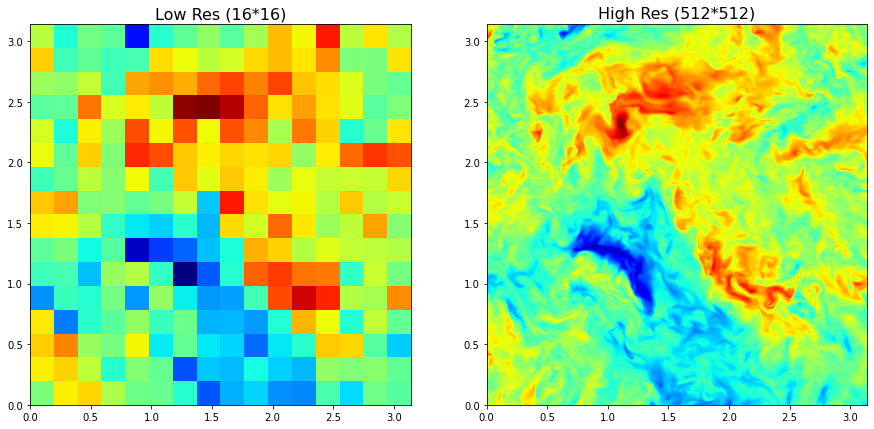

In [ ]:
#Compare low-res input to high-rest output
%matplotlib inline
import matplotlib.pyplot as plt

a = int(X_train.shape[0]**(1/2))
b = int(Y_train.shape[0]**(1/2))
lr = X_trainm[:,0].reshape(a,a)
hr = Y_trainm[:,0].reshape(b,b)

fig = plt.figure(figsize = (15, 15))
a = fig.add_subplot(121)
a.imshow(lr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('Low Res (16*16)',fontsize=16)

a = fig.add_subplot(122)
a.imshow(hr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512)',fontsize=16)

In [ ]:
#Setup Cross validation
from sklearn.model_selection import train_test_split

all_indices = list(range(X_train.shape[1]))

train, dev = train_test_split(all_indices, test_size=0.2)

X_playm = X_trainm[:,train]
X_devm = X_trainm[:,dev]
Y_playm = Y_trainm[:,train]
Y_devm = Y_trainm[:,dev]

In [ ]:
print(X_playm.shape,Y_playm.shape)
print(X_devm.shape,Y_devm.shape)

(256, 328) (262144, 328)
(256, 82) (262144, 82)


In [ ]:
# Build model
import tensorflow as tf
from tensorflow import keras
from keras import layers

deep_approx = keras.models.Sequential()
deep_approx.add(layers.Dense(350, input_dim=X_playm.shape[0], activation='relu'))
deep_approx.add(layers.Dense(400, activation='relu'))
deep_approx.add(layers.Dense(Y_playm.shape[0], activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_playm.transpose(), Y_playm.transpose(), 
            epochs=50,validation_data=(X_devm.transpose(), Y_devm.transpose()))

Epoch 1/50
11/11 [==============================] - 19s 1s/step - loss: 0.1525 - val_loss: 0.0894
Epoch 2/50
11/11 [==============================] - 15s 1s/step - loss: 0.0748 - val_loss: 0.0588
Epoch 3/50
11/11 [==============================] - 15s 1s/step - loss: 0.0494 - val_loss: 0.0429
Epoch 4/50
11/11 [==============================] - 16s 1s/step - loss: 0.0372 - val_loss: 0.0340
Epoch 5/50
11/11 [==============================] - 16s 1s/step - loss: 0.0302 - val_loss: 0.0276
Epoch 6/50
11/11 [==============================] - 15s 1s/step - loss: 0.0249 - val_loss: 0.0236
Epoch 7/50
11/11 [==============================] - 16s 1s/step - loss: 0.0212 - val_loss: 0.0208
Epoch 8/50
11/11 [==============================] - 15s 1s/step - loss: 0.0189 - val_loss: 0.0184
Epoch 9/50
11/11 [==============================] - 15s 1s/step - loss: 0.0168 - val_loss: 0.0166
Epoch 10/50
11/11 [==============================] - 15s 1s/step - loss: 0.0149 - val_loss: 0.0147
Epoch 11/50
11/11 [

In [ ]:
deep_approx.evaluate(X_testm.transpose(),Y_testm.transpose())

4/4 [==============================] - 1s 172ms/step - loss: 0.1675


0.1674874871969223

In [ ]:
deep_approx.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 350)               89950     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 400)               140400    
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 262144)            105119744 
Total params: 105,350,094
Trainable params: 105,350,094
Non-trainable params: 0
_________________________________________________________________


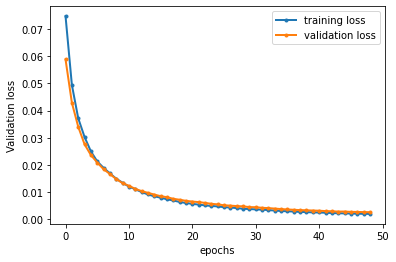

In [ ]:
idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [ ]:
#Check quality of reconstruction in-sample
from random import randint

c = np.unique(np.random.randint(low=0, high=X_trainm.shape[1]-1, size=(15,)))
d = np.unique(np.random.randint(low=0, high=X_testm.shape[1]-1, size=(15,)))

data_in = X_trainm.transpose()[c,:]
img_approx = deep_approx.predict(data_in)

data_out = X_testm.transpose()[d,:]
img_approx_out = deep_approx.predict(data_out)

print(data_in.shape,img_approx.shape)
print(data_out.shape,img_approx_out.shape)
print(Ymean.shape,Xmean.shape)

(15, 256) (15, 262144)
(15, 256) (15, 262144)
(262144, 1) (256, 1)


In [ ]:
#Plot reconstruction vs original in-sample
a = int(X_train.shape[0]**(1/2))
b = int(Y_train.shape[0]**(1/2))

lr = data_in.transpose() + Xmean
hr = img_approx.transpose() + Ymean
hr_orig = Y_trainm[:,c] + Ymean

print(hr.shape,hr_orig.shape)

(262144, 15) (262144, 15)


In [ ]:
#MAE
mean_error = np.abs(hr - hr_orig)
insamplemean = np.mean(np.mean(mean_error,axis=0))
insamplevar = np.std(np.mean(mean_error,axis=0))

print(insamplemean,insamplevar)

0.03084197 0.005549036


Text(0.5, 1.0, 'High Res (512*512) Original')

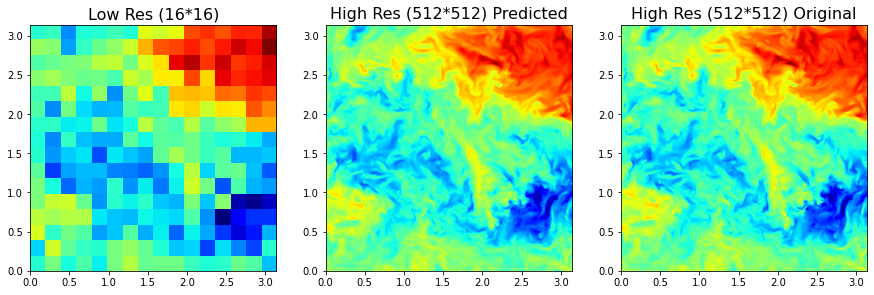

In [ ]:
lr = lr[:,5].reshape(a,a)
hr = hr[:,5].reshape(b,b)
hr_orig = hr_orig[:,5].reshape(b,b)

fig = plt.figure(figsize = (15, 15))
a = fig.add_subplot(131)
a.imshow(lr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('Low Res (16*16)',fontsize=16)

a = fig.add_subplot(132)
a.imshow(hr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Predicted',fontsize=16)

a = fig.add_subplot(133)
a.imshow(hr_orig,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Original',fontsize=16)

In [ ]:
#Plot reconstruction vs original in-sample
a = int(X_test.shape[0]**(1/2))
b = int(Y_test.shape[0]**(1/2))

lr = data_out.transpose() + Xmean
hr = img_approx_out.transpose() + Ymean
hr_orig = Y_testm[:,d] + Ymean

print(hr.shape,hr_orig.shape)

(262144, 15) (262144, 15)


In [ ]:
#MAE
mean_error = np.abs(hr - hr_orig)
outsamplemean = np.mean(np.mean(mean_error,axis=0))
outsamplevar = np.std(np.mean(mean_error,axis=0))

print(outsamplemean,outsamplevar)

0.31427178 0.06570334


Text(0.5, 1.0, 'High Res (512*512) Original')

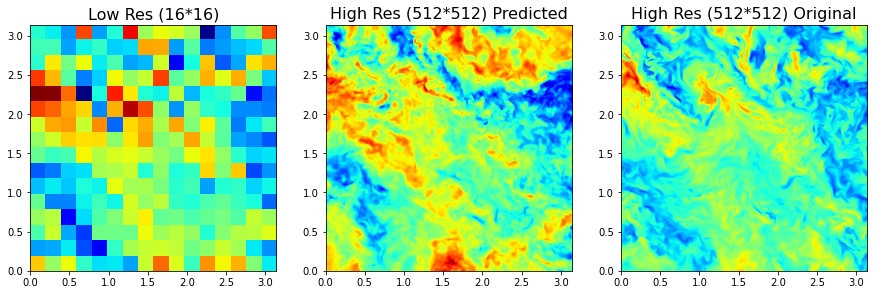

In [ ]:
lr = lr[:,5].reshape(a,a)
hr = hr[:,5].reshape(b,b)
hr_orig = hr_orig[:,5].reshape(b,b)

fig = plt.figure(figsize = (15, 15))
a = fig.add_subplot(131)
a.imshow(lr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('Low Res (16*16)',fontsize=16)

a = fig.add_subplot(132)
a.imshow(hr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Predicted',fontsize=16)

a = fig.add_subplot(133)
a.imshow(hr_orig,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Original',fontsize=16)

In [ ]:
#Try reconstruction for t=2

#Get u_z along the x-y plane for t=1
input_x = X.reshape(X.shape[0]**2,X.shape[2],X.shape[3],X.shape[4])
input_x = np.reshape(input_x[:,:,2,1],(input_x.shape[0],input_x.shape[1]))

#Setup output
output_y = Y.reshape(Y.shape[0]**2,Y.shape[2],Y.shape[3],Y.shape[4])
output_y = np.reshape(output_y[:,:,2,1],(output_y.shape[0],output_y.shape[1]))

#Demean
xmn = input_x.mean(axis=1,keepdims=True)
ymn = output_y.mean(axis=1,keepdims=True)

inxm = input_x - xmn
outym = output_y - ymn

e = np.unique(np.random.randint(low=0, high=input_x.shape[1]-1, size=(15,)))

data_try = inxm.transpose()[e,:]
img_approx_try = deep_approx.predict(data_try)

In [ ]:
#Plot reconstruction for t=257
a = int(inxm.shape[0]**(1/2))
b = int(outym.shape[0]**(1/2))

lr = data_try.transpose() + xmn
hr = img_approx_try.transpose() + ymn
hr_orig = outym[:,e] + ymn

print(hr.shape,hr_orig.shape)

(262144, 15) (262144, 15)


In [ ]:
#MAE
mean_error = np.abs(hr - hr_orig)
outsamplemean = np.mean(np.mean(mean_error,axis=0))
outsamplevar = np.std(np.mean(mean_error,axis=0))

print(outsamplemean,outsamplevar)

0.29032618 0.034060623


Text(0.5, 1.0, 'High Res (512*512) Original')

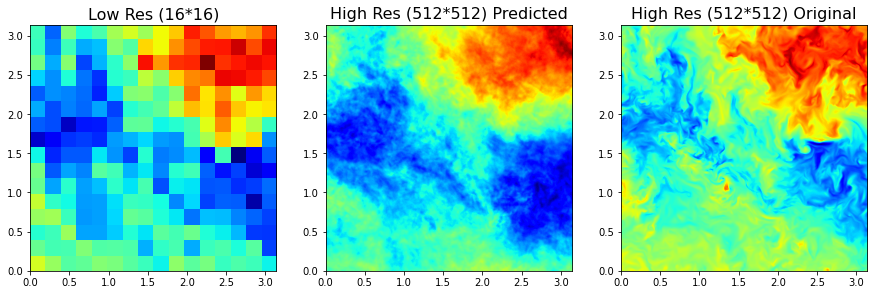

In [ ]:
lr = lr[:,5].reshape(a,a)
hr = hr[:,5].reshape(b,b)
hr_orig = hr_orig[:,5].reshape(b,b)

fig = plt.figure(figsize = (15, 15))
a = fig.add_subplot(131)
a.imshow(lr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('Low Res (16*16)',fontsize=16)

a = fig.add_subplot(132)
a.imshow(hr,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Predicted',fontsize=16)

a = fig.add_subplot(133)
a.imshow(hr_orig,extent = [0, 3.14, 0, 3.14],cmap='jet')
a.set_title('High Res (512*512) Original',fontsize=16)